# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, json, math, librosa

import IPython.display as ipd

from pandas import DataFrame

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import load_model 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
path = '/content/drive/My Drive/MSBD5001/Project/data/genres_original/'
music_dataset = []
genre_target = [] 
for root, dirs, files in os.walk(path):
  for name in files:
    filename = os.path.join(root, name)
    music_dataset.append(filename)
    genre_target.append(filename.split("/")[8])

# data detail
print(music_dataset,"\n", genre_target)

['/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00000.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00004.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00003.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00001.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00002.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00012.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00014.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00006.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00011.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00015.wav', '/content/drive/My Drive/MSBD5001/Project/data/genres_original/disco/disco.00007.wav', '/content/drive/My Drive/MSBD5001/Project/

In [ ]:
DATASET_PATH = '/content/drive/My Drive/MSBD5001/Project/data/genres_original/'
JSON_PATH = "/content/drive/My Drive/MSBD5001/Project/data/data_3_withnum.json"
SAMPLE_RATE = 22050 #22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
"""
num_mfcc: dnumber of MFCCs to return
n_fft: length of the FFT window
hop_length: number of samples between successive frames. (overlap)
num_segments: 
"""
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=10): #10
  # dictionary to store mapping, labels, and MFCCs
  data = {"mapping": [], "labels": [], "mfcc": [], "num": []}
  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  # loop through all genre sub-folder
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    # ensure we're processing a genre sub-folder level
    if dirpath is not dataset_path:
      # save genre label (i.e., sub-folder name) in the mapping
      semantic_label = dirpath.split("/")[-1]
      data["mapping"].append(semantic_label)
      print("\nProcessing: {}".format(semantic_label))

      # process all audio files in genre sub-dir
      for f in filenames:
      # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        # process all segments of audio file
        for d in range(num_segments):
          # calculate start and finish sample for current segment
          start = samples_per_segment * d
          finish = start + samples_per_segment

          # extract mfcc
          mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T

          # store only mfcc feature with expected number of vectors
          if len(mfcc) == num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            song_num = file_path.split(".")[-2]
            data["num"].append(song_num)
            # print(song_num)
            print("{}, segment:{}".format(file_path, d+1))

  # save MFCCs to json file
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)

In [ ]:
# REMEMBER to change the JSON_PATH before saving a new file!!!!
# save_mfcc(DATASET_PATH, JSON_PATH)

流式输出内容被截断，只能显示最后 5000 行内容。
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00006.wav, segment:7
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00006.wav, segment:8
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00006.wav, segment:9
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00006.wav, segment:10
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:1
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:2
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:3
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:4
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:5
/content/drive/My Drive/MSBD5001/Project/data/genres_original/pop/pop.00003.wav, segment:6
/content/drive/My Drive/MSBD5001/Project/data/genres_original/

# Split the songs by the whole song

In [ ]:
JSON_PATH = "/content/drive/My Drive/MSBD5001/Project/data/data_3_withnum.json"
alldata_30 = pd.read_json(JSON_PATH, orient='index')
alldata_30.head()
alldata_30 = alldata_30.T[['labels','mfcc','num','mapping']]
mapping = alldata_30[['mapping']].dropna()
alldata_30 = alldata_30[['labels','mfcc','num']]
alldata_30[['labels','num']] = alldata_30[['labels','num']].astype(int)
mapping
alldata_30

,labels,mfcc,num
0,0,"[[-122.41178736075774, 119.85343910107034, -45...",0
1,0,"[[-150.3350960532749, 119.44760979309356, 23.3...",0
2,0,"[[1.289023159283525, 57.33944702712627, -21.03...",0
3,0,"[[-211.20796655445432, 129.54400002901107, 37....",0
4,0,"[[-130.5213344816688, 107.94688654197554, -6.0...",0
...,...,...,...
9991,9,"[[-252.34704014417105, 138.77909563610115, -18...",96
9992,9,"[[-268.34186044662505, 115.39303443655939, -14...",96
9993,9,"[[-120.41978273648402, 138.9696881133989, -17....",96
9994,9,"[[-121.86237688664208, 137.3999088783043, -85....",96


In [ ]:
alldata_30_test = alldata_30[alldata_30['num']>75]
alldata_30_train = alldata_30[alldata_30['num']<=75]
dict_30_test = alldata_30_test.to_dict('list')
dict_mapping = mapping.to_dict('list')
dict_mapping.update(dict_30_test)
f_alldata_30_test = "/content/drive/My Drive/MSBD5001/Project/data/data_30_test.json"
with open(f_alldata_30_test, "w") as fp:
  json.dump(dict_mapping, fp, indent=4) 

In [ ]:
# 这里改成3s的！！注意文件名
JSON_PATH = "/content/drive/My Drive/MSBD5001/Project/data/data_3_withnum.json"
alldata_3 = pd.read_json(JSON_PATH, orient='index')
alldata_3 = alldata_3.T[['labels','mfcc','num','mapping']]
mapping = alldata_3[['mapping']].dropna()
alldata_3 = alldata_3[['labels','mfcc','num']]
alldata_3[['labels','num']] = alldata_3[['labels','num']].astype(int)
alldata_3_test = alldata_3[alldata_3['num']>75]
alldata_3_train = alldata_3[alldata_3['num']<=75]
dict_3_test = alldata_3_test.to_dict('list')
dict_3_train = alldata_3_train.to_dict('list')
dict_mapping = mapping.to_dict('list')
dict_3_test.update(dict_mapping)
dict_3_train.update(dict_mapping)
dict
f_alldata_3_test = "/content/drive/My Drive/MSBD5001/Project/data/data_3_test.json"
f_alldata_3_train = "/content/drive/My Drive/MSBD5001/Project/data/data_3_train.json"
with open(f_alldata_3_test, "w") as fp:
  json.dump(dict_3_test, fp, indent=4) 
with open(f_alldata_3_train, "w") as fp:
  json.dump(dict_3_train, fp, indent=4) 

# Model & Train

In [ ]:
#DATA_PATH = "/content/drive/My Drive/MSBD5001/Project/data/genres_original/data_3.json"
DATA_PATH = "/content/drive/My Drive/MSBD5001/Project/data/data_3_train.json"

def load_data(data_path):
  """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
  """
  with open(data_path, "r") as fp:
    data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  z = np.array(data['mapping'])
  # n = np.array(data['num'])

  return X,y,z


def plot_history(history):
  """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
  """

  fig, axs = plt.subplots(2)
  plt.subplots_adjust(wspace =0, hspace =0.5)
  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  # adjust distance between the two subplots
  plt.subplots_adjust(wspace=0.2)

  plt.show()

In [ ]:
# def prepare_datasets(test_size, validation_size):
def prepare_datasets(validation_size): 
  """Loads data and splits it into train, validation and test sets.
  :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
  :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
  :return X_train (ndarray): Input training set
  :return X_validation (ndarray): Input validation set
  :return X_test (ndarray): Input test set
  :return y_train (ndarray): Target training set
  :return y_validation (ndarray): Target validation set
  :return y_test (ndarray): Target test set
  :return z : Mappings for data
  """

  # load data
  X, y, z = load_data(DATA_PATH)
    
  # create train, validation and test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size)
  # X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
  # add an axis to input sets
  X_train = X_train[..., np.newaxis]
  # X_validation = X_validation[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_test, y_train, y_test, z

In [ ]:
def build_model(input_shape):
  """Generates CNN model
  :param input_shape (tuple): Shape of input set
  :return model: CNN model
  """

  # build network topology
  model = keras.Sequential()

  # 1st conv layer
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

  # 2nd conv layer
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

  # 3rd conv layer
  model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # flatten output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.5))

  # output layer
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

def predict(model, X, y):
  """Predict a single sample using the trained model
  :param model: Trained classifier
  :param X: Input data
  :param y (int): Target
  """
  # add a dimension to input data for sample - model.predict() expects a 4d array in this case
  X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

  # perform prediction
  prediction = model.predict(X)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)
    
  # get mappings for target and predicted label
  target = z[y]
  predicted = z[predicted_index]
  return target, predicted

In [ ]:
X_train, X_test, y_train, y_test, z = prepare_datasets(0.001)
# X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0, 0.25)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=100)

# train model
# epochs = 30
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=35)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30)


Model: "sequential_2"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
conv2d_6 (Conv2D)                            (None, 128, 18, 64)                     640            
____________________________________________________________________________________________________
batch_normalization_6 (BatchNormalization)   (None, 128, 18, 64)                     256            
____________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)               (None, 64, 9, 64)                       0              
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                            (None, 62, 7, 64)                       36928          
_____________________________________________________________________

# Analyses

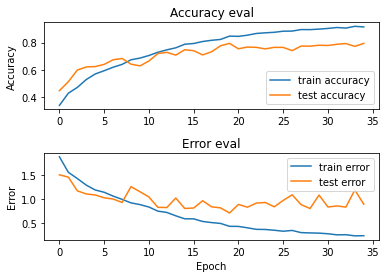

57/57 - 0s - loss: 0.9880 - accuracy: 0.7813

Test accuracy: 0.7813186645507812


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
# test on 30s data
X_30, y_30, z_30 = load_data("/content/drive/My Drive/MSBD5001/Project/data/data_30.json")
X_30 = X_30[..., np.newaxis]
print(X_train.shape, X_validation.shape, X_test.shape, X_30.shape)

model_best = load_model("/content/drive/My Drive/MSBD5001/Project/data/model/model0.7975000143051147.h5")
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model_best.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

test_loss_30, test_acc_30 = model.evaluate(X_30, y_30, verbose=2)
test_loss_, test_acc_ = model_best.evaluate(X_test, y_test, verbose=2)
# print(np.allclose(model_best.predict(X_test), model.predict(X_test)))
print('\nTest accuracy:', test_acc_30)
print('\nTest accuracy:', test_acc_)


NameError: ignored

In [ ]:
# test on data_3_test
# For one piece of music, if the more than half of the segment belong to one genre, we will recognize is as our result

# load_test_data
def load_test_data(data_path):
  """Loads test dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
  """
  with open(data_path, "r") as fp:
    data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  z = np.array(data['mapping'])
  n = np.array(data['num'])

  return X,y,z,n

In [ ]:
pd.options.display.multi_sparse = False

DATA_PATH_3_test = "/content/drive/My Drive/MSBD5001/Project/data/data_3_test.json"
X_3_test, y_3_test, z_3_test, n_3_test = load_test_data(DATA_PATH_3_test)
X_3_test = X_3_test[..., np.newaxis]
# print(X_3_test.shape)
# error, test_acc = model.evaluate(X_3_test, y_3_test, verbose=2)
# print(test_acc)

test_3 = pd.read_json(DATA_PATH_3_test, orient='index')
test_3 = test_3.T[['labels','mfcc','num','mapping']]
mapping = test_3[['mapping']].dropna()
test_3 = test_3[['labels','mfcc','num']]
test_3[['labels','num']] = test_3[['labels','num']].astype(int)

test_3_predict = model.predict(np.array(X_3_test))
test_3_predict = np.argmax(test_3_predict, axis=1)
test_3['prediction'] = test_3_predict
analyze_test_3 = test_3[['labels','num','prediction']]

analyze_test_3['acc'] = analyze_test_3.apply(lambda x: x['labels']==x['prediction'], axis=1)
analyze_test_3 = analyze_test_3.groupby(['labels', 'num', 'prediction']).count()
analyze_test_3 = analyze_test_3.reset_index()
analyze_test_4 = analyze_test_3[['labels','num','acc']].groupby(['labels', 'num']).max()

analyze_test_5 = analyze_test_4.merge(analyze_test_3, on=['labels','num','acc']) 
analyze_test_5 = analyze_test_5.groupby(['labels','num','acc']).first()
analyze_test_5 = analyze_test_5.reset_index()
analyze_test_5['acc'] = analyze_test_5.apply(lambda x: x['labels']==x['prediction'], axis=1)

final = analyze_test_5['acc'].mean()
print(final)

# test_3_0 = test_3[test_3['labels']==0]
# test_3_0_98 = test_3_0[test_3_0['num']==98]
# y_test_3_0_98 = test_3_0_98[['labels']].values.flatten()
# X_test_3_0_98 = np.array(list(test_3_0_98[['mfcc']].to_dict('list').values())).reshape(10,130,20)
# X_test_3_0_98 = X_test_3_0_98[..., np.newaxis]
# error, test_acc = model.evaluate(X_test_3_0_98, y_test_3_0_98, verbose=2)
# print(test_acc)
# test_3_final = analyze_test_3['acc_all'].mean()
# test_3_final

test_loss_, test_acc_ = model.evaluate(X_3_test, y_3_test, verbose=2)

# analyze_test_5
print(test_acc_)

0.6375
75/75 - 0s - loss: 2.4500 - accuracy: 0.5550
0.5550000071525574


In [ ]:
model_best.summary(line_length=100)

Model: "sequential_10"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
conv2d_30 (Conv2D)                           (None, 128, 18, 64)                     640            
____________________________________________________________________________________________________
batch_normalization_30 (BatchNormalization)  (None, 128, 18, 64)                     256            
____________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D)              (None, 64, 9, 64)                       0              
____________________________________________________________________________________________________
conv2d_31 (Conv2D)                           (None, 62, 7, 64)                       36928          
____________________________________________________________________

In [ ]:
if test_acc > 0.80:
  save_path = "/content/drive/My Drive/MSBD5001/Project/data/model/model" + str(test_acc) + ".h5"
  model.save(save_path)
# model.save('/content/drive/My Drive/MSBD5001/Project/data/model/my_model.h5')

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
target, predicted = predict(model, X_to_predict, y_to_predict)
print("Target: " + str(target) + "  Predicted: " + str(predicted))

Target: country  Predicted: ['country']


In [ ]:
def plot_confusion_matrix(cm, normalize=True, cmap=plt.cm.Blues):
  if normalize:
    title = 'Normalized confusion matrix'
  else:
    title = 'Confusion matrix, without normalization'
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    print('Normalized confusion matrix')
  else:
    print('Confusion matix, without normalization')
  print(cm)
  #print(cm)

  fig, ax = plt.subplots(figsize=(8, 6))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  classes=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      xticklabels=classes, 
      yticklabels=classes,
      title='Confusion matrix',
      ylabel='True label',
      xlabel='Predicted label')
  
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  
  # Loop over data dimensions and create text annotations.
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j]), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  plt.show()
  return ax

In [ ]:
t = [0]*len(X_test)
p = [0]*len(X_test)
for i in range(len(X_test)):
  t[i], p[i] = predict(model, X_test[i], y_test[i])

Normalized confusion matrix
[[0.8  0.   0.06 0.   0.04 0.   0.01 0.   0.03 0.06]
 [0.   0.89 0.02 0.   0.   0.08 0.   0.   0.   0.  ]
 [0.03 0.   0.67 0.07 0.   0.02 0.   0.03 0.07 0.09]
 [0.   0.   0.02 0.73 0.1  0.01 0.01 0.02 0.07 0.02]
 [0.01 0.   0.   0.02 0.87 0.   0.03 0.04 0.02 0.01]
 [0.04 0.03 0.05 0.04 0.   0.76 0.   0.   0.02 0.05]
 [0.01 0.   0.   0.02 0.01 0.   0.93 0.   0.   0.04]
 [0.   0.   0.04 0.03 0.05 0.01 0.   0.78 0.02 0.06]
 [0.01 0.01 0.01 0.03 0.12 0.   0.01 0.02 0.78 0.02]
 [0.02 0.02 0.07 0.09 0.05 0.01 0.08 0.04 0.03 0.62]]


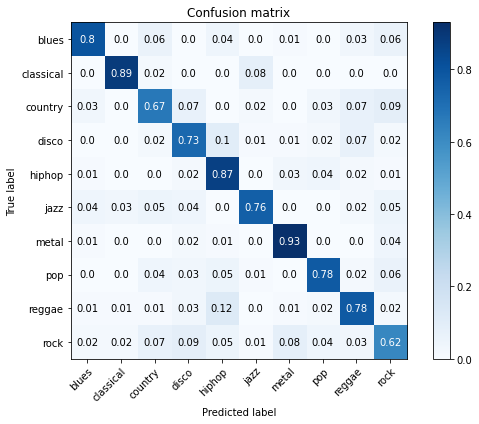

In [ ]:
cm = confusion_matrix(y_true=t, y_pred=p)
plot_confusion_matrix(cm)